<a href="https://colab.research.google.com/github/Vaibhavi15-04/Image-Captioning/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [ ]:
!pip -q install kaggle

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm
import cv2
from glob import glob

In [ ]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "vaibhavibothra",
                 "key": "77eac7f6414916cdc9c47ee9d89aa0d3"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [ ]:
captions = pd.read_csv('/content/data/captions.txt')
captions['image'] = captions['image'].apply(
    lambda x: f'/content/data/Images/{x}')
captions.head()

,image,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
images_path = 'data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

Data Preprocessing And EDA

In [ ]:
images[:5]

['data/Images/3335097235_538f4777c3.jpg',
 'data/Images/3285214689_f0219e9671.jpg',
 'data/Images/437527058_189f2a7eef.jpg',
 'data/Images/3727740053_3baa94ffcb.jpg',
 'data/Images/1235681222_819231767a.jpg']

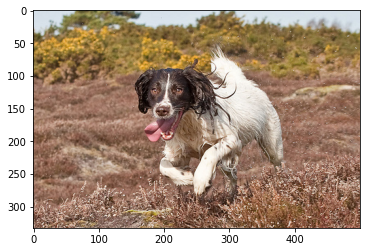

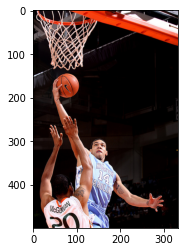

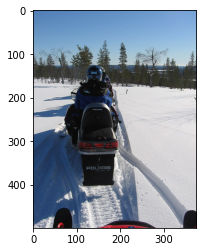

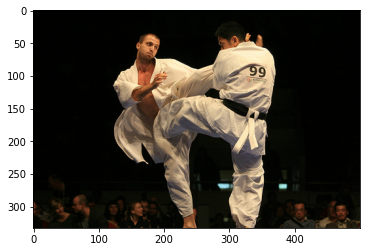

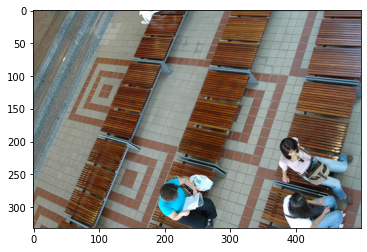

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

In [ ]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)


1/1 [==============================] - 0s 25ms/step
50
1/1 [==============================] - 0s 25ms/step
100
1/1 [==============================] - 0s 26ms/step
150
1/1 [==============================] - 0s 29ms/step


In [ ]:
len(images_features)

800

In [ ]:
caption_path = 'data/captions.txt'

In [ ]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
len(captions)

40457

In [ ]:
captions[1].split(',')[1]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split(',')[0] 
        caption = i.split(',')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [ ]:
len(captions_dict)

200

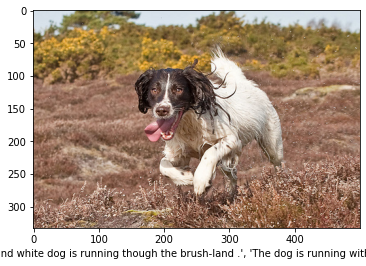

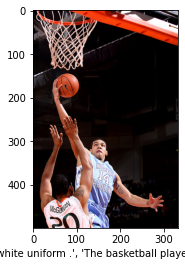

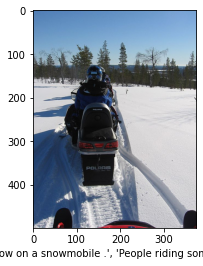

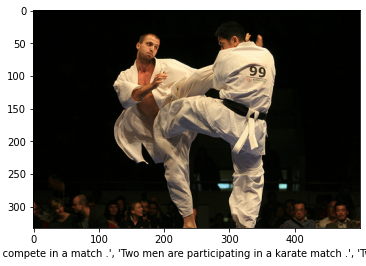

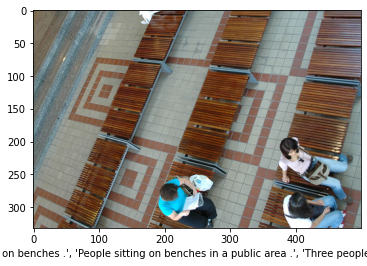

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

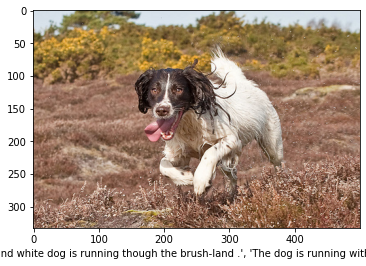

In [ ]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = 'data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [ ]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified
    

In [ ]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [ ]:
from keras.utils import to_categorical


In [ ]:
count_words={}
count=1
for k,vv in captions_dict.items():
  for v in vv:
    for word in v.split():
      if word not in count_words:
        count_words[word]=count
        count+=1

In [ ]:


for k, vv in captions_dict.items():
  encoded=[]
  for v in vv:
        for word in v.split():
          encoded.append(count_words[word])
        captions_dict[k][vv.index(v)]=encoded

In [ ]:
MAX_LEN = 0
for k, vv in captions_dict.items():
  for v in vv:
    if len(v)>MAX_LEN:
      MAX_LEN=len(v)
      


In [ ]:
Batch_size = 5000
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [ ]:
len(count_words)

1331

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(65370, 65370, 65370)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [ ]:

X.shape, y_in.shape, y_out.shape

((64775, 2048), (64775, 99), (64775, 1332))

In [ ]:
X[1510]

array([0.32132468, 0.49508208, 0.3246623 , ..., 0.10280983, 0.69222915,
       0.05545978], dtype=float32)

Model


In [ ]:

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(1332)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 95, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 95, 128)           167808    
                                                                 
 lstm (LSTM)                 (None, 95, 256)           394240    
                            

In [ ]:
model.fit([X, y_in], y_out, batch_size=256, epochs=50)

In [ ]:
inv_dict = {v:k for k, v in count_words.items()}

Saving A Model

In [ ]:
model.save('model.h5')